# **1. Introduction**

## 1.1 Project Overview

The FIFA World Cup is one of the most prestigious sporting events globally, uniting nations in a celebration of football excellence. The Qatar 2022 FIFA World Cup, in particular, marked a historic tournament with unique challenges and unforgettable moments. In this project, we aim to leverage machine learning to predict match outcomes for the Qatar 2022 World Cup and its qualifiers. By training a Multi-Layer Perceptron (MLP) neural network, we will analyze historical performance data to forecast match results, ultimately simulating the entire tournament to predict its hypothetical outcome based on the model’s insights.

## 1.2 Dataset Overview

The dataset combines Road to Qatar 2022 Qualifiers and the actual Qatar 2022 World Cup matches, providing a comprehensive view of team performance across two critical stages of the tournament. Each entry includes detailed attributes that capture team dynamics, historical performance, and match-specific conditions. Below is a breakdown of the key features:

| **Attribute**            | **Description**                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| `home_team`              | The national team designated as the home team for the match.                   |
| `home_goals`             | Number of goals scored by the home team in the match.                          |
| `away_goals`             | Number of goals scored by the away team in the match.                          |
| `away_team`              | The national team designated as the away team for the match.                   |
| `wcm`                    | Binary flag (`1` = World Cup match, `0` = qualifier match).                    |
| `dif_inter_match`        | Difference in total international matches played (home team - away team).      |
| `dif_inter_match_won`    | Difference in international matches won (home - away).                         |
| `dif_inter_match_lost`   | Difference in international matches lost (home - away).                        |
| `dif_inter_match_tie`    | Difference in international matches tied (home - away).                        |
| `dif_inter_goals_sco`    | Difference in goals scored in international matches (home - away).             |
| `dif_inter_goals_con`    | Difference in goals conceded in international matches (home - away).           |
| `dif_wc_match`           | Difference in total World Cup matches played (home - away).                    |
| `dif_wc_match_won`       | Difference in World Cup matches won (home - away).                             |
| `dif_wc_match_lost`      | Difference in World Cup matches lost (home - away).                            |
| `dif_wc_match_tied`      | Difference in World Cup matches tied (home - away).                            |
| `dif_wc_goals_sco`       | Difference in goals scored in World Cup matches (home - away).                 |
| `dif_wc_goals_con`       | Difference in goals conceded in World Cup matches (home - away).               |
| `status`                 | Match result: `1` = home win, `2` = tie, `3` = home loss.                      |

---

# **2. Environment Setup**

## 2.1 Import Liraries

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

from collections import defaultdict

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

## 2.2 Configurationa and Settings

In [51]:
STATUS_HOME_WON = 1
STATUS_TIE = 2
STATUS_AWAY_WON = 3

HOME_WON = 0
TIE = 1
AWAY_WON = 2

BATCH_SIZE_TORCH_DATA_LOADER = 32
NUM_EPOCHS = 50

# **3. Exploratory Data Analysis**

## 3.1 Load Dataset

In [3]:
df = pd.read_csv('matches.csv')

In [4]:
df = df.drop('Unnamed: 0', axis=1)

## 3.2 Dataset Overview

Understand the dataset’s structure and sanity checks.

In [5]:
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")

Rows: 17812, Columns: 18



In [6]:
df.head()

,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,Spain,1,0,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,Portugal,1,0,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,Northern Ireland,7,0,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1
3,Italy,4,2,Switzerland,0,-438.0,-120.0,-259.0,-59.0,-595.0,-936.0,46.0,33.0,0.0,13.0,78.0,13.0,1
4,Portugal,2,0,France,0,-191.0,-101.0,-61.0,-29.0,-388.0,-353.0,-36.0,-20.0,-9.0,-7.0,-71.0,-42.0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17812 entries, 0 to 17811
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   home_team             17812 non-null  object 
 1   home_goals            17812 non-null  int64  
 2   away_goals            17812 non-null  int64  
 3   away_team             17812 non-null  object 
 4   wcm                   17812 non-null  int64  
 5   dif_inter_match       17812 non-null  float64
 6   dif_inter_match_won   17812 non-null  float64
 7   dif_inter_match_lost  17812 non-null  float64
 8   dif_inter_match_tie   17812 non-null  float64
 9   dif_inter_goals_sco   17812 non-null  float64
 10  dif_inter_goals_con   17812 non-null  float64
 11  dif_wc_match          17812 non-null  float64
 12  dif_wc_match_won      17812 non-null  float64
 13  dif_wc_match_lost     17812 non-null  float64
 14  dif_wc_match_tied     17812 non-null  float64
 15  dif_wc_goals_sco   

## 3.3 Match Outcomes Distribution

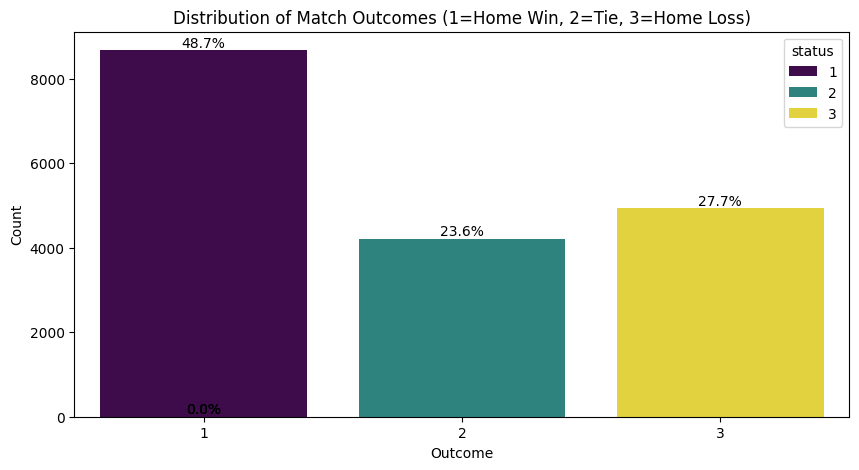

In [8]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x='status', hue='status', palette='viridis')
plt.title("Distribution of Match Outcomes (1=Home Win, 2=Tie, 3=Home Loss)")
plt.xlabel("Outcome")
plt.ylabel("Count")

total = len(df)
for p in ax.patches:
    percentage = f"{100 * p.get_height() / total:.1f}%"
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.show()

## 3.4 Numerical Features Exploration

### 3.4.1 Plot Distribution

In [9]:
numerical_cols = (df.select_dtypes(include=['int64', 'float64'])
                  .columns
                  .drop(['status', 'wcm']))

In [10]:
def plot_num_cols_hist(df: pd.DataFrame, num_cols: pd.Index):
  n_cols = 3
  n_rows = -(-len(num_cols) // n_cols)

  plt.figure(figsize=(5 * n_cols, 4 * n_rows))

  for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=20, color='teal')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

  plt.suptitle("Distribution of Numerical Features with KDE", y=1.02)
  plt.tight_layout()
  plt.show()

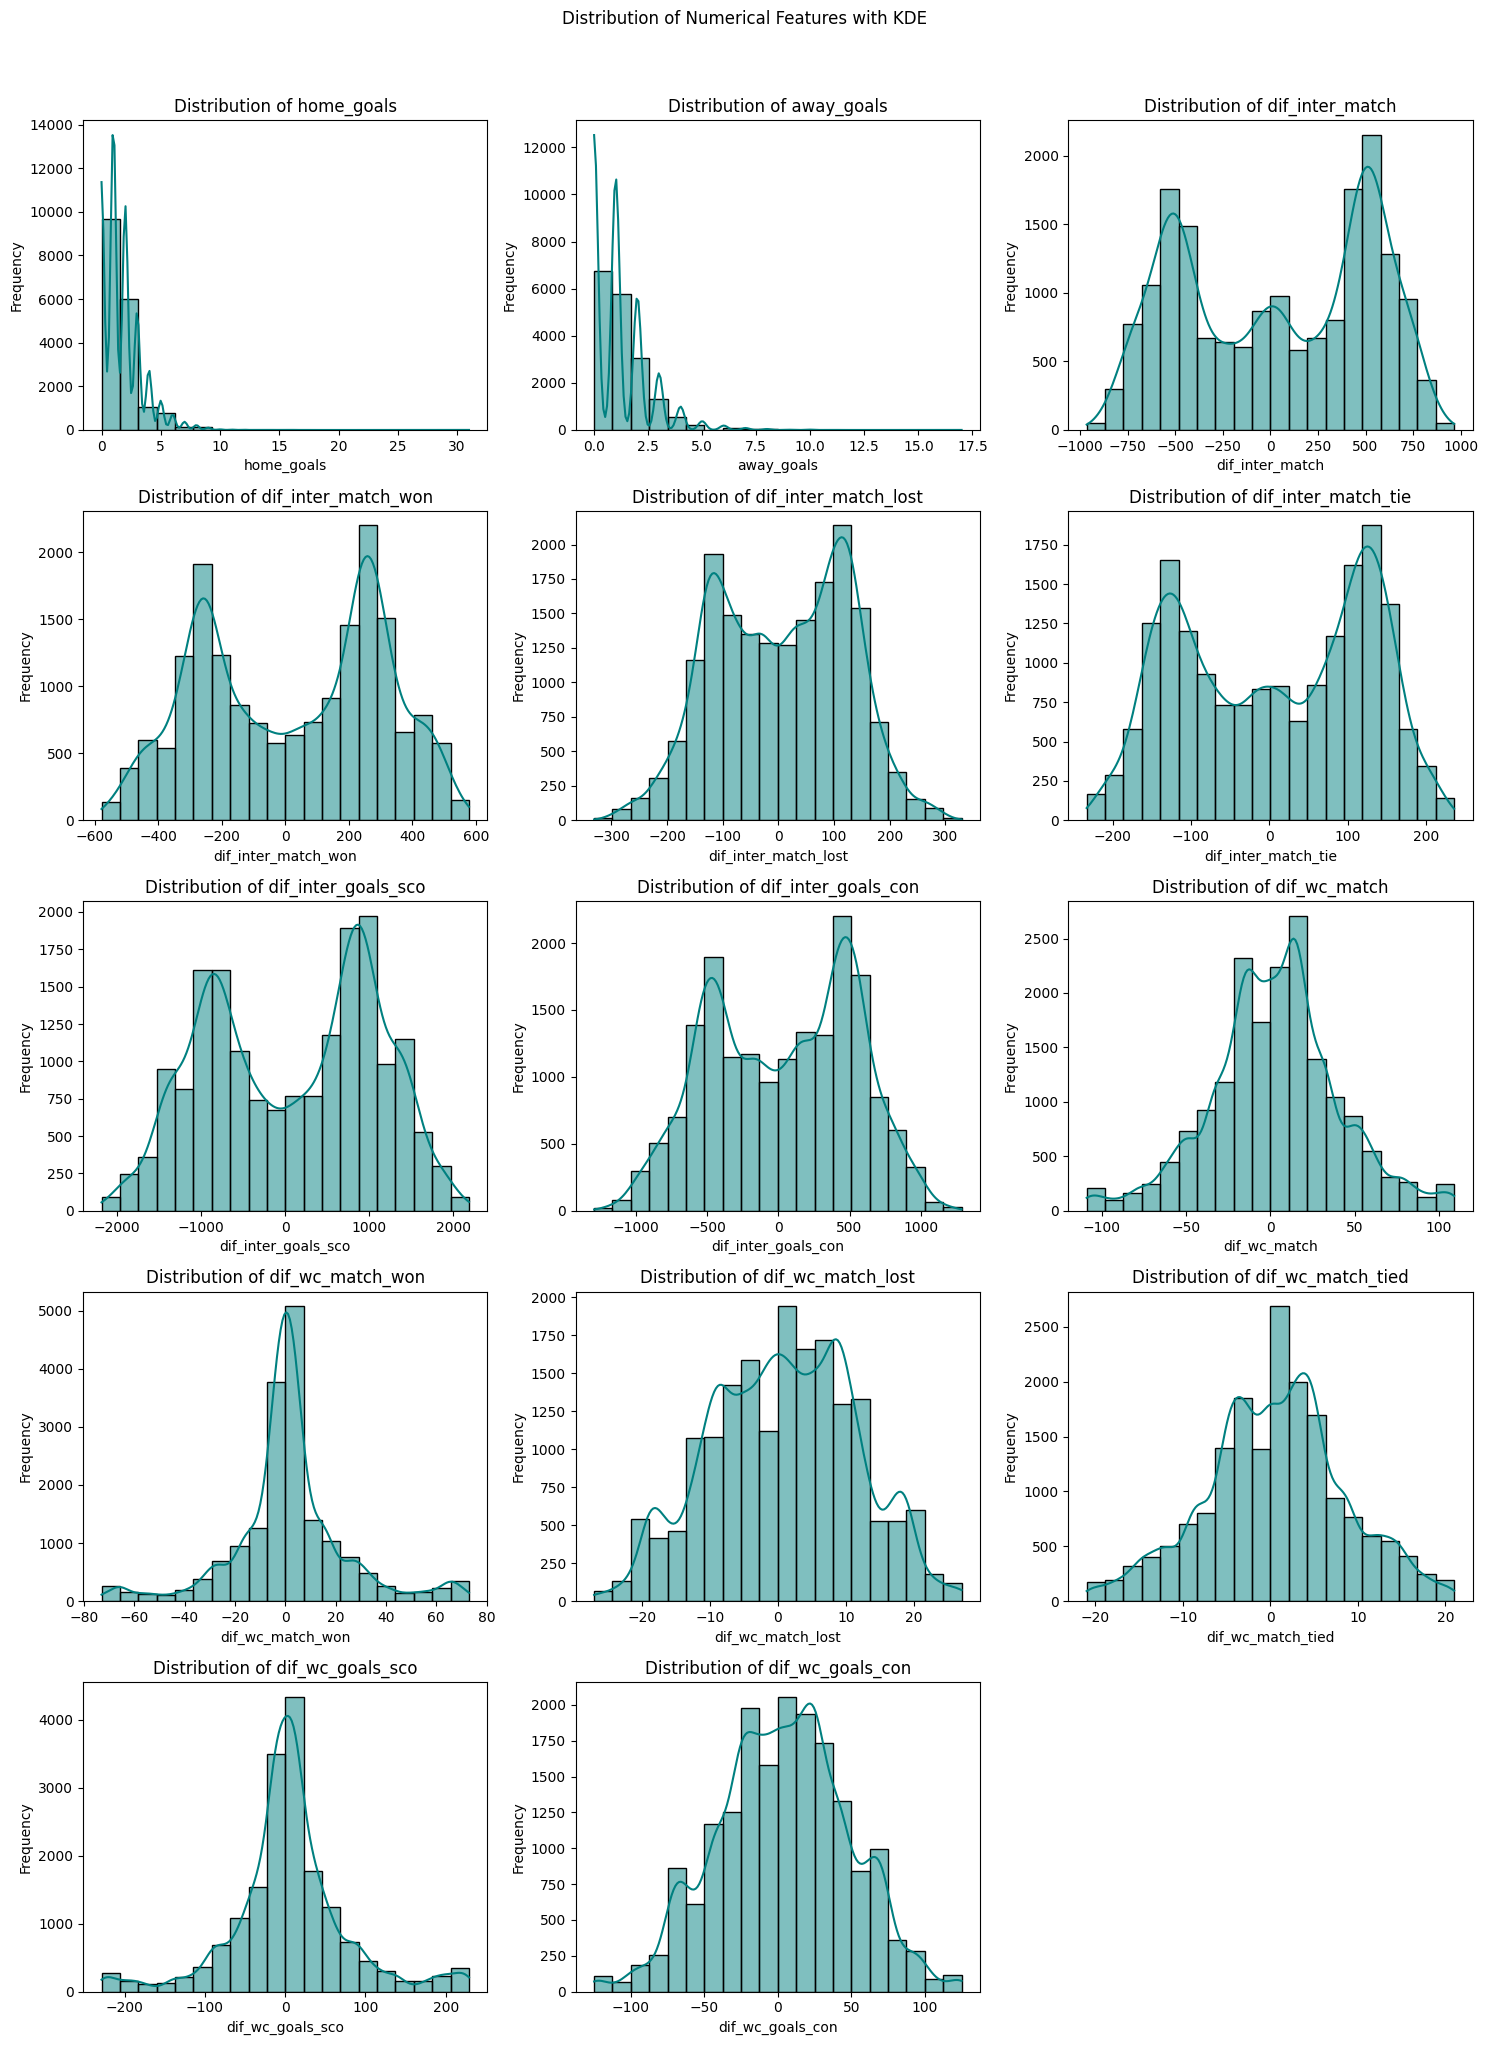

In [11]:
plot_num_cols_hist(df, numerical_cols)

### 3.4.2 Correlation Analysis

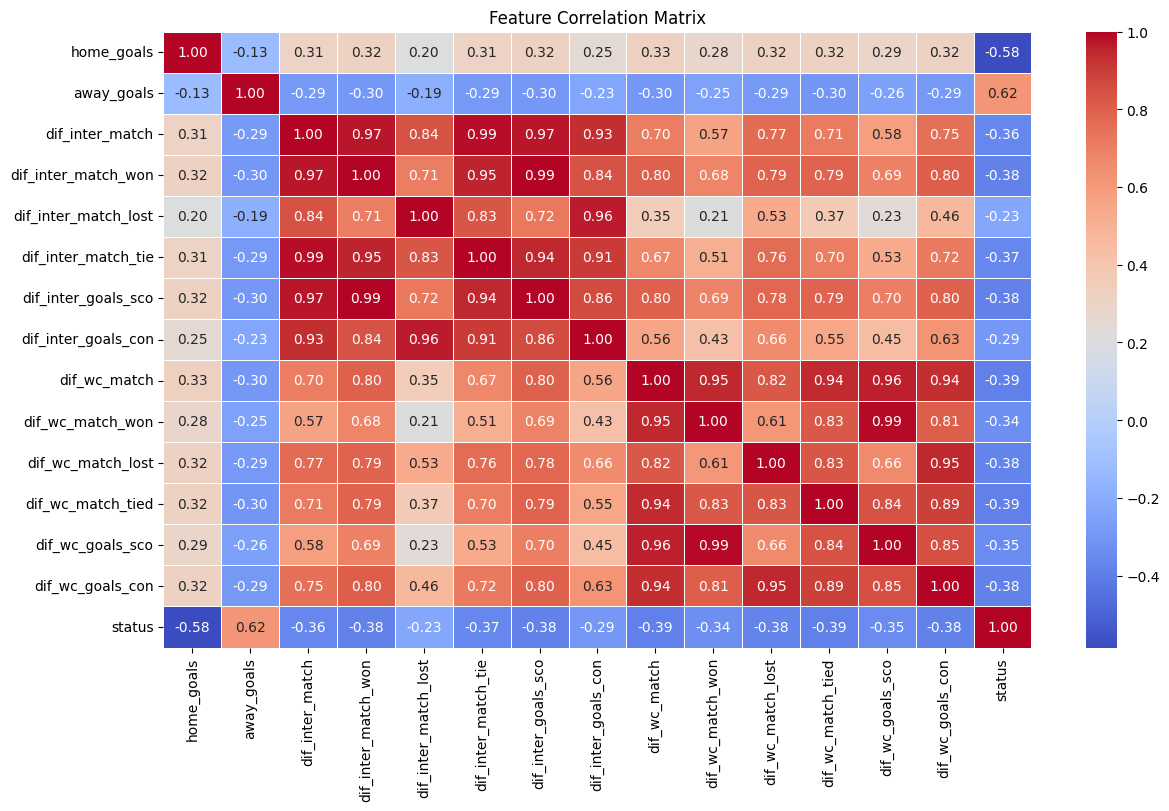

In [12]:
plt.figure(figsize=(14, 8))
corr_matrix = df[numerical_cols.to_list() + ['status']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

## 3.5 Home vs. Away Performance

Validates the **home advantage** phenomenon.

In [13]:
home_win_rate = len(df[df['status'] == STATUS_HOME_WON]) / len(df)
away_win_rate = len(df[df['status'] == STATUS_AWAY_WON]) / len(df)

print(f"Home Win Rate: {home_win_rate:.2%}")
print(f"Away Win Rate: {away_win_rate:.2%}")

print(f"\nAverage Goals (Home): {df['home_goals'].mean():.2f}")
print(f"Average Goals (Away): {df['away_goals'].mean():.2f}")

Home Win Rate: 48.70%
Away Win Rate: 27.66%

Average Goals (Home): 1.70
Average Goals (Away): 1.14


# **4. Data Preparation**

Prepare this data to feed it to a model

## 4.1 Handling Missing Values

In [14]:
df.isnull().sum()

,0
home_team,0
home_goals,0
away_goals,0
away_team,0
wcm,0
dif_inter_match,0
dif_inter_match_won,0
dif_inter_match_lost,0
dif_inter_match_tie,0
dif_inter_goals_sco,0


## 4.2 Data Filtering

The process of training the model is on games whose wcm attribute is 0 because we want to have a final prediction on the winner of the World Cup, we need the world cup matches’ data to remain unseen for our model.

In [15]:
not_wcm_df = df[df['wcm'] == 0]
wcm_df = df[df['wcm'] == 1]

print(f"Training Matches (Qualifiers): {len(not_wcm_df)}")
print(f"Unseen World Cup Matches: {len(wcm_df)}")

Training Matches (Qualifiers): 16912
Unseen World Cup Matches: 900


## 4.3 Feature Selection

Then we will need to select X and y. X is our set of features and y is the label which is to be predicted. In the context of this dataset, X will be all columns except the following columns:

1. home_team
2. home_goals
3. away_goals
4. away_team
5. status

and y will be the status column. The reason for which we omitted the above columns is obvious for columns home_goals and away_goals because the result of the match is specified if we know the number of goals scored by home and away sides. On the other hand, we omit name of teams from our features because we want to force our model to learn the patterns of the match according to its status; otherwise it will be biased to name of teams; For example if Germany has more wins than Spain, the prediction of the model will be Germany without considering the other criterias.

In [16]:
columns_to_drop = ['home_team', 'away_team', 'home_goals', 'away_goals', 'status']
X = not_wcm_df.drop(columns=columns_to_drop)
y = not_wcm_df['status']

## 4.4 Label encoding

Converts categorical labels (1=home win, 2=tie, 3=home loss) into numerical indices (0, 1, 2).

Required for models that expect labels to start at 0 (e.g., PyTorch).

In [17]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

## 4.5 Train Test Split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

In [19]:
print(f"Train set size: {X_train.shape[0]} matches")
print(f"Validation set size: {X_val.shape[0]} matches")
print("\nClass distribution in y_train:", np.bincount(y_train))
print("Class distribution in y_val:", np.bincount(y_val))

Train set size: 11838 matches
Validation set size: 5074 matches

Class distribution in y_train: [5720 2808 3310]
Class distribution in y_val: [2451 1204 1419]


## 4.6 Normalization

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## 4.7 Convert Data to PyTorch Tensors

- Tensor Types:

    - FloatTensor for features (continuous values).
    - LongTensor for labels (class indices 0, 1, 2).

- Why TensorDataset?

    Wraps tensors into a dataset object for cleaner batch iteration.

- Why DataLoader?

    Handles batching, shuffling, and parallel loading.
    Set shuffle=True only for training data.

In [21]:
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val)

In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

In [23]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE_TORCH_DATA_LOADER,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE_TORCH_DATA_LOADER,
                        shuffle=False)

In [24]:
print("Tensor Shapes:")
print(f"Train features: {X_train_tensor.shape}")
print(f"Train labels: {y_train_tensor.shape}")

print(f"\nExample batch from train_loader:")
for batch_X, batch_y in train_loader:
    print(f"Features batch shape: {batch_X.shape}")
    print(f"Labels batch shape: {batch_y.shape}")
    break

Tensor Shapes:
Train features: torch.Size([11838, 13])
Train labels: torch.Size([11838])

Example batch from train_loader:
Features batch shape: torch.Size([32, 13])
Labels batch shape: torch.Size([32])


# **5. Model Definitaion**

We create a custom PyTorch model class for the World Cup prediction task.

A Multi-Layer Perceptron (MLP) to predict FIFA World Cup match outcomes.
Inherits from PyTorch's nn.Module and implements __init__ and forward methods.
    
Architecture:
- Input Layer: Size = number of features
- Hidden Layers: 3 fully connected layers with ReLU activation and dropout
- Output Layer: 3 neurons (home win, tie, home loss)

In [25]:
class WorldCupPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super(WorldCupPredictor, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X):
      X = F.relu(self.fc1(X))
      X = self.dropout(X)
      X = F.relu(self.fc2(X))
      X = self.dropout(X)
      X = F.relu(self.fc3(X))
      X = self.fc4(X)
      return X

In [26]:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using device: {device}")

Using device: cpu


In [27]:
input_dim = X_train_tensor.shape[1]
print(input_dim)

13


In [28]:
model = WorldCupPredictor(input_dim).to(device)

# **6. Model Training**

## 6.1 Define Loss Function (Criterion)

CrossEntropyLoss is ideal for multi-class classification tasks. It combines LogSoftmax and NLLLoss to handle raw logits (unnormalized scores) directly.

$$
\text{Loss} = - \sum_{i=1}^{C} y_i \cdot \log(\hat{y}_i)
$$

Where:

* $C$: number of classes
* $y_i$: true label for class $i$ (1 if it's the correct class, 0 otherwise — one-hot encoded)
* $\hat{y}_i$: predicted probability for class $i$

If the correct class is $k$, the formula simplifies to:

$$
\text{Loss} = -\log(\hat{y}_k)
$$


Why Use Cross-Entropy?

- Directly works with class indices (0, 1, 2) instead of one-hot encoded labels.
- Automatically applies softmax to outputs.s

In [29]:
criterion = nn.CrossEntropyLoss()

## 6.2 Define Optimizer

The Adam optimizer is used to update model weights based on gradients.

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

## 6.3 Learning Rate Scheduling

Reduce the learning rate dynamically when loss plateaus:

In [31]:
scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.5,
                              patience=2)

## 6.3 Training Loop

A training loop consists of:

1.   **Forward Pass**: Compute predictions.
2.   **Loss Calculation**: Compare predictions to ground truth.
3.   **Backward Pass**: Compute gradients.
4.   **Weight Update**: Adjust parameters using gradients.



In [32]:
num_epochs = NUM_EPOCHS

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()


    epoch_loss = running_loss / len(train_loader)
    scheduler.step(epoch_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {epoch_loss:.4f} | LR: {current_lr:.5f}")

print("Training complete")

Epoch [1/50] | Loss: 0.9751 | LR: 0.01000
Epoch [2/50] | Loss: 0.9663 | LR: 0.01000
Epoch [3/50] | Loss: 0.9614 | LR: 0.01000
Epoch [4/50] | Loss: 0.9624 | LR: 0.01000
Epoch [5/50] | Loss: 0.9602 | LR: 0.01000
Epoch [6/50] | Loss: 0.9594 | LR: 0.01000
Epoch [7/50] | Loss: 0.9597 | LR: 0.01000
Epoch [8/50] | Loss: 0.9571 | LR: 0.01000
Epoch [9/50] | Loss: 0.9578 | LR: 0.01000
Epoch [10/50] | Loss: 0.9578 | LR: 0.01000
Epoch [11/50] | Loss: 0.9583 | LR: 0.00500
Epoch [12/50] | Loss: 0.9528 | LR: 0.00500
Epoch [13/50] | Loss: 0.9508 | LR: 0.00500
Epoch [14/50] | Loss: 0.9506 | LR: 0.00500
Epoch [15/50] | Loss: 0.9519 | LR: 0.00500
Epoch [16/50] | Loss: 0.9508 | LR: 0.00500
Epoch [17/50] | Loss: 0.9502 | LR: 0.00500
Epoch [18/50] | Loss: 0.9498 | LR: 0.00500
Epoch [19/50] | Loss: 0.9494 | LR: 0.00500
Epoch [20/50] | Loss: 0.9490 | LR: 0.00500
Epoch [21/50] | Loss: 0.9499 | LR: 0.00500
Epoch [22/50] | Loss: 0.9494 | LR: 0.00500
Epoch [23/50] | Loss: 0.9500 | LR: 0.00250
Epoch [24/50] | Loss

# **7. Evaluating Model**

1. Accuracy Reporting

  - What: Overall percentage of correct predictions
  - Why: Simple benchmark metric - anything >50% is good for football
  - Football Context: Beating the "always predict home win" baseline (~45-55% in most leagues)

2. Classification Report

  - Precision: % of correct predictions for each class
(e.g., "When we predict Home Win, how often are we right?")
  - Recall: % of actual instances correctly predicted
 (e.g., "What % of real Home Wins did we catch?")
  - F1-Score: Harmonic mean of precision/recall
  - Football Insight: Ties are hardest to predict (usually <30% F1)

3. Confusion Matrix

  - Visualizes: Where model confuses classes
  - Key Patterns:
    - Diagonal dominance = good performance
    - Off-diagonal flows show common mistakes
    - Ties often confused with close wins/losses

4. Football-Specific Metrics

  - Home Win Recall: How well we detect actual home victories
  - Tie Detection Rate: Critical for tournament simulations
  - Away Win Precision: Confidence in rare predictions

In [33]:
def evaluate_model(model, dataloader, phase_name="Test"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = ['Home Win', 'Tie', 'Home Loss']

    present_classes = np.unique(all_labels + all_preds)
    target_names = [class_names[i] for i in present_classes]

    accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"\n{phase_name} Accuracy: {accuracy:.2f}%")

    print(f"\n{classification_report(all_labels, all_preds, target_names=class_names,digits=3,zero_division=0)}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{phase_name} Set Confusion Matrix')
    plt.show()

    print("\nFootball Insights:")
    try:
        print(f"- Home Win Recall: {100*cm[0,0]/cm[0].sum():.1f}%")
    except ZeroDivisionError:
        print("- No Home Win cases in data")

    try:
        print(f"- Tie Detection Rate: {100*cm[1,1]/cm[1].sum():.1f}%")
    except ZeroDivisionError:
        print("- No Tie cases in data")

    try:
        print(f"- Away Win Precision: {100*cm[2,2]/cm[:,2].sum():.1f}%")
    except ZeroDivisionError:
        print("- No Away Win predictions")


Test Accuracy: 56.35%

              precision    recall  f1-score   support

    Home Win      0.611     0.799     0.693      2451
         Tie      0.000     0.000     0.000      1204
   Home Loss      0.482     0.634     0.548      1419

    accuracy                          0.563      5074
   macro avg      0.364     0.478     0.413      5074
weighted avg      0.430     0.563     0.488      5074



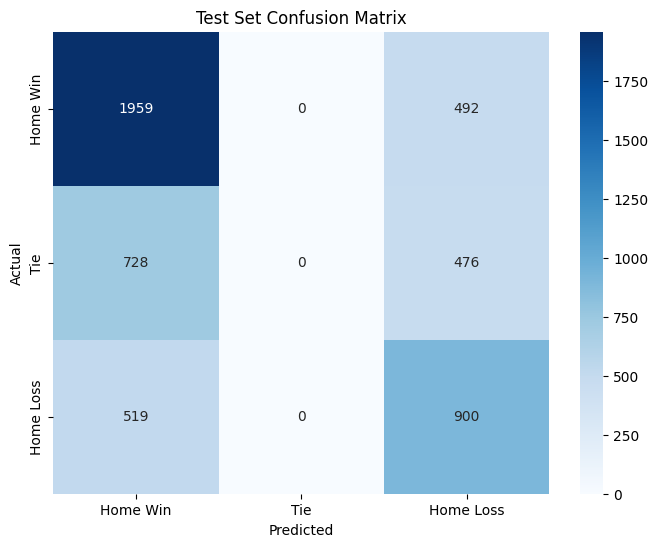


Football Insights:
- Home Win Recall: 79.9%
- Tie Detection Rate: 0.0%
- Away Win Precision: 48.2%


In [34]:
evaluate_model(model, val_loader)

# **8. Run FIFA World CUP!**

In [53]:
class WorldCupSimulator:
    def __init__(self, model, features_df, scaler):
        self.groups = {
            'A': ['Qatar', 'Ecuador', 'Senegal', 'Netherlands'],
            'B': ['England', 'Iran', 'USA', 'Wales'],
            'C': ['Argentina', 'Saudi Arabia', 'Mexico', 'Poland'],
            'D': ['France', 'Australia', 'Denmark', 'Tunisia'],
            'E': ['Spain', 'Costa Rica', 'Germany', 'Japan'],
            'F': ['Belgium', 'Canada', 'Morocco', 'Croatia'],
            'G': ['Brazil', 'Serbia', 'Switzerland', 'Cameroon'],
            'H': ['Portugal', 'Ghana', 'Uruguay', 'South Korea']
        }

        self.model = model
        self.features_df = features_df
        self.scaler = scaler

        self.model.eval()

        self.group_results = {}
        self.knockout_bracket = {}

        self.feature_columns = ([
            col for col in features_df.columns
            if col not in ['home_team', 'away_team', 'home_goals',
                           'away_goals', 'status']
        ])

    def get_match_features(self, home_team, away_team):
        match_row = self.features_df[
            (self.features_df['home_team'] == home_team) &
            (self.features_df['away_team'] == away_team)
        ]

        if len(match_row) > 0:
            features = match_row[self.feature_columns].iloc[-1].values
        else:
            reverse_match = self.features_df[
                (self.features_df['home_team'] == away_team) &
                (self.features_df['away_team'] == home_team)
            ]

            if len(reverse_match) > 0:
                features = reverse_match[self.feature_columns].iloc[-1].values
                features = -features
            else:
                print(f"Warning: No data found for {home_team} vs {away_team}, using random selection")
                return None

        features_tensor = torch.FloatTensor(features).unsqueeze(0)

        features_scaled = self.scaler.transform(features.reshape(1, -1))
        features_tensor = torch.FloatTensor(features_scaled)

        return features_tensor

    def predict_match(self, home_team, away_team, is_knockout=False):
      features = self.get_match_features(home_team, away_team)
      if features is None:
        return random.choice([HOME_WON, TIE, AWAY_WON])

      with torch.no_grad():
        features = features.to(self.device if hasattr(self, 'device') else 'cpu')
        outputs = self.model(features)
        _, preds = torch.max(outputs, 1)
        predicted_outcome = preds.cpu().numpy()[0] if preds.dim() > 0 else preds.cpu().numpy()


      if is_knockout and predicted_outcome == TIE:
        probabilities = F.softmax(outputs, dim=1).squeeze().cpu().numpy()

        home_prob = probabilities[HOME_WON] + probabilities[TIE] / 2
        away_prob = probabilities[AWAY_WON] + probabilities[TIE] / 2

        predicted_outcome = HOME_WON if home_prob > away_prob else AWAY_WON

      return predicted_outcome

    def simulate_group_stage(self):
        print("FIFA WORLD CUP 2022 QATAR SIMULATION")
        print("="*50)
        print("\nGROUP STAGE SIMULATION")
        print("-"*30)

        group_standings = {}

        for group_name, teams in self.groups.items():
            print(f"\n🔸 GROUP {group_name}: {', '.join(teams)}")

            standings = {}
            for team in teams:
                standings[team] = {'points': 0, 'wins': 0, 'draws': 0, 'losses': 0}

            for i in range(4):
                for j in range(i+1, 4):
                    home_team, away_team = teams[i], teams[j]
                    result = self.predict_match(home_team, away_team, is_knockout=False)

                    if result == HOME_WON:
                        standings[home_team]['points'] += 3
                        standings[home_team]['wins'] += 1
                        standings[away_team]['losses'] += 1
                        print(f"  {home_team} defeats {away_team}")
                    elif result == AWAY_WON:
                        standings[away_team]['points'] += 3
                        standings[away_team]['wins'] += 1
                        standings[home_team]['losses'] += 1
                        print(f"  {away_team} defeats {home_team}")
                    else:
                        standings[home_team]['points'] += 1
                        standings[away_team]['points'] += 1
                        standings[home_team]['draws'] += 1
                        standings[away_team]['draws'] += 1
                        print(f"  {home_team} draws with {away_team}")

            sorted_teams = sorted(standings.items(),
                                key=lambda x: (-x[1]['points'], -x[1]['wins'], x[1]['losses']))

            group_standings[group_name] = sorted_teams

            print(f"\n  📋 GROUP {group_name} FINAL STANDINGS:")
            print("  " + "-"*50)
            print("  {:15} {:>3} {:>3} {:>3} {:>3}".format("Team", "Pts", "W", "D", "L"))
            print("  " + "-"*50)

            for i, (team, stats) in enumerate(sorted_teams):
                qualifier = "🟢" if i < 2 else "🔴"
                print("  {} {:15} {:>3} {:>3} {:>3} {:>3}".format(
                    qualifier, team, stats['points'], stats['wins'],
                    stats['draws'], stats['losses']))

        self.group_results = group_standings
        return group_standings

    def get_qualified_teams(self):
        qualified = []
        for group_name, standings in self.group_results.items():

            qualified.extend([standings[0][0], standings[1][0]])
        return qualified

    def simulate_knockout_stage(self):
        print("\n\n KNOCKOUT STAGE")
        print("-"*30)

        round_16_matches = [
            (self.group_results['A'][0][0], self.group_results['B'][1][0]),  # 1A vs 2B
            (self.group_results['C'][0][0], self.group_results['D'][1][0]),  # 1C vs 2D
            (self.group_results['E'][0][0], self.group_results['F'][1][0]),  # 1E vs 2F
            (self.group_results['G'][0][0], self.group_results['H'][1][0]),  # 1G vs 2H
            (self.group_results['B'][0][0], self.group_results['A'][1][0]),  # 1B vs 2A
            (self.group_results['D'][0][0], self.group_results['C'][1][0]),  # 1D vs 2C
            (self.group_results['F'][0][0], self.group_results['E'][1][0]),  # 1F vs 2E
            (self.group_results['H'][0][0], self.group_results['G'][1][0])   # 1H vs 2G
        ]

        return self._simulate_knockout_rounds(round_16_matches)

    def _simulate_knockout_rounds(self, matches):
        round_names = ["Round of 16", "Quarter-finals", "Semi-finals", "Final"]
        current_round = 0
        current_matches = matches

        results = {}

        while len(current_matches) >= 1:
            round_name = round_names[min(current_round, 3)]
            print(f"\n {round_name.upper()}")

            winners = []
            round_results = []

            for home_team, away_team in current_matches:
                result = self.predict_match(home_team, away_team, is_knockout=True)

                if result == HOME_WON:
                    winner = home_team
                    print(f"  {home_team} defeats {away_team} → {winner} advances")
                elif result == AWAY_WON:
                    winner = away_team
                    print(f"  {away_team} defeats {home_team} → {winner} advances")
                else:
                    winner = home_team if np.random.random() < 0.5 else away_team
                    print(f"  {home_team} vs {away_team} (Decided on penalties) → {winner} advances")

                winners.append(winner)
                round_results.append((home_team, away_team, winner, result))

            results[round_name] = round_results

            if len(winners) > 1:
                current_matches = [(winners[i], winners[i+1]) for i in range(0, len(winners), 2)]
            else:
                print(f"\n WORLD CUP CHAMPION: {winners[0]}! ")
                results['Champion'] = winners[0]
                break

            current_round += 1

        return results

    def run_full_simulation(self):
        np.random.seed(42)
        random.seed(42)
        torch.manual_seed(42)

        group_results = self.simulate_group_stage()

        knockout_results = self.simulate_knockout_stage()


        print("\n" + "="*50)
        print("🏆 TOURNAMENT SUMMARY")
        print("="*50)

        qualified = self.get_qualified_teams()
        print(f"\n✅ Teams that qualified to Round of 16:")
        for i, team in enumerate(qualified, 1):
            print(f"{i:2d}. {team}")

        if 'Champion' in knockout_results:
            print(f"\n🥇 WORLD CUP CHAMPION: {knockout_results['Champion']}")

        return {
            'group_results': group_results,
            'knockout_results': knockout_results,
            'qualified_teams': qualified
        }

In [54]:
simulator = WorldCupSimulator(model, df, scaler)
results = simulator.run_full_simulation()

FIFA WORLD CUP 2022 QATAR SIMULATION

GROUP STAGE SIMULATION
------------------------------

🔸 GROUP A: Qatar, Ecuador, Senegal, Netherlands
  Qatar defeats Ecuador
  Senegal defeats Qatar
  Qatar defeats Netherlands
  Ecuador defeats Senegal
  Netherlands defeats Ecuador
  Senegal defeats Netherlands

  📋 GROUP A FINAL STANDINGS:
  --------------------------------------------------
  Team            Pts   W   D   L
  --------------------------------------------------
  🟢 Qatar             6   2   0   1
  🟢 Senegal           6   2   0   1
  🔴 Ecuador           3   1   0   2
  🔴 Netherlands       3   1   0   2

🔸 GROUP B: England, Iran, USA, Wales
  Iran defeats England
  England draws with USA
  England defeats Wales
  Iran defeats USA
  Iran defeats Wales
  USA defeats Wales

  📋 GROUP B FINAL STANDINGS:
  --------------------------------------------------
  Team            Pts   W   D   L
  --------------------------------------------------
  🟢 Iran              9   3   0   0
  🟢 Eng